<a href="https://colab.research.google.com/github/Byeon-MJ/Background_Change_Semantic_Segmentation/blob/main/Semantic_Segmentation_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation을 활용한 배경사진 변경
- Reference : https://github.com/kairess/semantic-segmentation-pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torchvision import transforms, models
import cv2

## Download and Load Model
- https://pytorch.org/vision/stable/models.html

In [ ]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

## Create Color Palette

In [ ]:
labels = ['background', 'aeroplane', 'bicycle', 'bird',
          'boat', 'bottle', 'bus', 'car', 'cat',
          'chair', 'cow', 'diningtable', 'dog', 'horse',
          'motorbike', 'person', 'pottedplant', 'sheep',
          'sofa', 'train', 'tvmonitor']

In [ ]:
cmap = plt.cm.get_cmap('tab20c')
colors= (cmap(np.arange(cmap.N)) * 255).astype(np.int)[:, :3].tolist()
np.random.seed(2020)
np.random.shuffle(colors)
colors.insert(0, [0, 0, 0])
colors = np.array(colors, dtype=np.uint8)

<ipython-input-5-6c623c926f3e>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  colors= (cmap(np.arange(cmap.N)) * 255).astype(np.int)[:, :3].tolist()


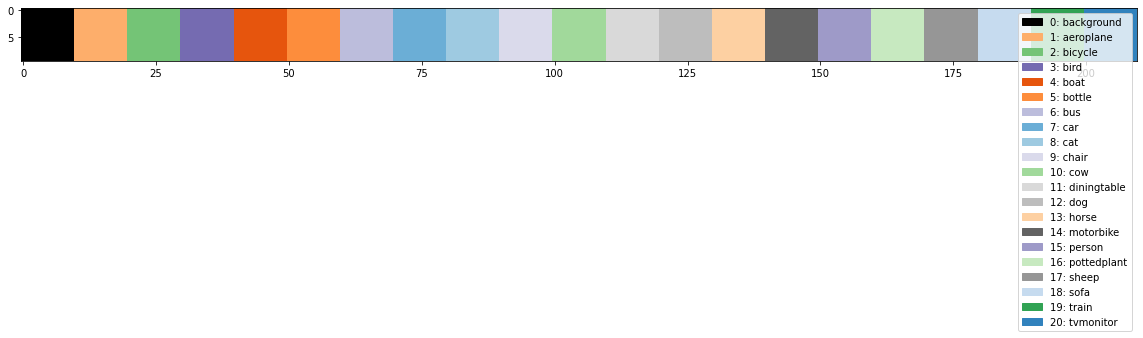

In [ ]:
palette_map = np.empty((10, 0, 3), dtype=np.uint8)
legend = []

for i in range(21):
    legend.append(mpatches.Patch(color=np.array(colors[i]) / 255., 
                                 label=f'{i}: {labels[i]}'))
    c = np.full((10, 10, 3), colors[i], dtype=np.uint8)
    palette_map = np.concatenate([palette_map, c], axis=1)

plt.figure(figsize=(20, 2))
plt.legend(handles=legend)
plt.imshow(palette_map)
plt.show()

## Segment Function

In [ ]:
def segment(net, img):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    
    output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

    r = Image.fromarray(output_predictions).resize((img.shape[1], img.shape[0]))
    r.putpalette(colors)

    return r, output_predictions

## Result

In [ ]:
img = np.array(Image.open('/content/gdrive/MyDrive/Project/Background_Image_Change_Semantic_Segmentation/Images/02.jpg'))

In [ ]:
img.shape

(959, 640, 3)

In [ ]:
fg_h, fg_w, _ = img.shape

In [ ]:
segment_map, pred = segment(model, img)

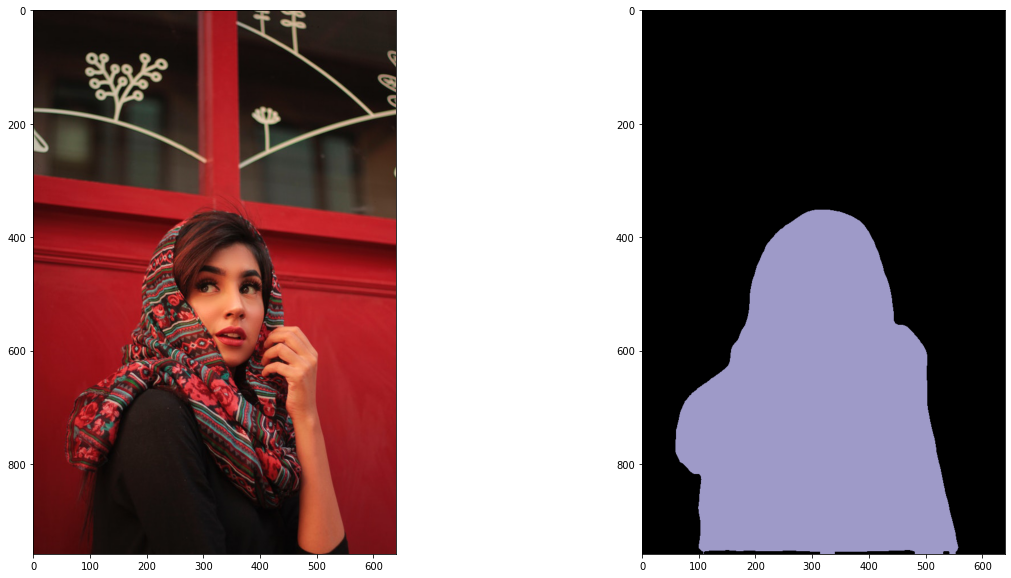

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(segment_map)
plt.show()

## Load Background Image and Resize
- make same size as foreground

In [ ]:
background = np.array(Image.open('/content/gdrive/MyDrive/Project/Background_Image_Change_Semantic_Segmentation/Images/bg02.jpg'))

In [ ]:
background.shape

(960, 640, 3)

In [ ]:
bg_h, bg_w, _ = background.shape

In [ ]:
# fit to fg width
background = cv2.resize(background, dsize=(fg_w, int(fg_w * bg_h / bg_w)))
bg_h, bg_w, _ = background.shape

In [ ]:
margin = (bg_h - fg_h) // 2

if margin > 0:  # bg가 더 크면 크기에 맞게 위아래 자르기
    background = background[margin:-margin, :, :]
else:           # bg가 더 작으면 위아래 채워주기
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin),
                                    left=0, right=0, borderType=cv2.BORDER_REPLICATE)

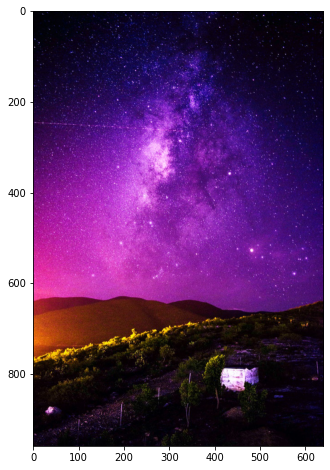

In [ ]:
# final resize
background = cv2.resize(background, dsize=(fg_w, fg_h))

plt. figure(figsize=(12, 8))
plt.imshow(background)
plt.show()

## Separate Foreground and Background

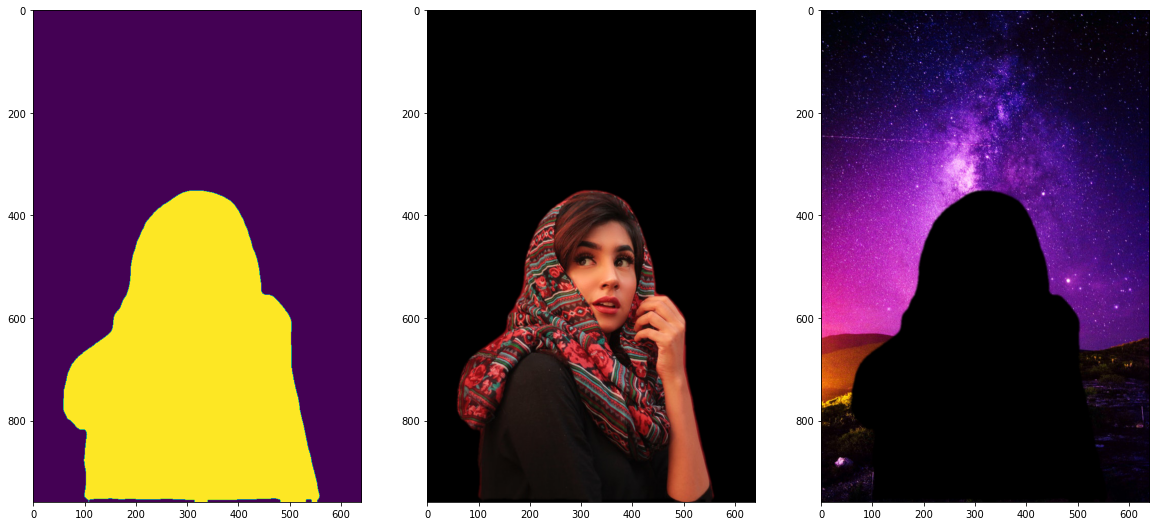

In [ ]:
mask = (pred == 15).astype(float) * 255  # 15 : person
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

alpha = alpha / 255.  # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2)  # (height, width, 3)

foreground = cv2.multiply(alpha, img.astype(float))
background = cv2.multiply(1. - alpha, background.astype(float))

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mask)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))
plt.show()

In [ ]:
foreground.shape

(959, 640, 3)

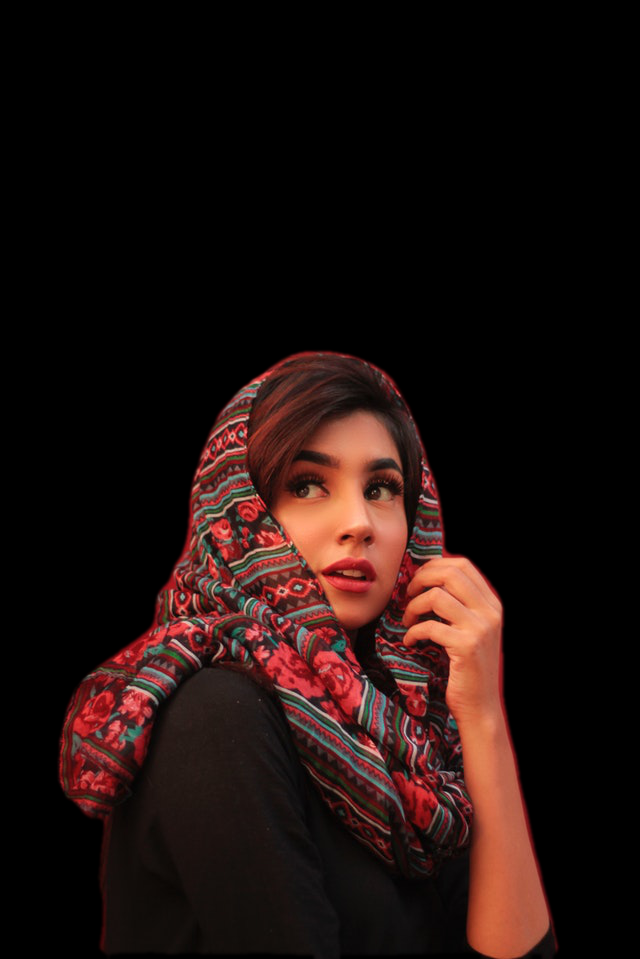

In [ ]:
from google.colab.patches import cv2_imshow
foreground_img = cv2.cvtColor(foreground.astype(np.uint8), cv2.COLOR_RGB2BGR)
cv2_imshow(foreground_img)

## Result

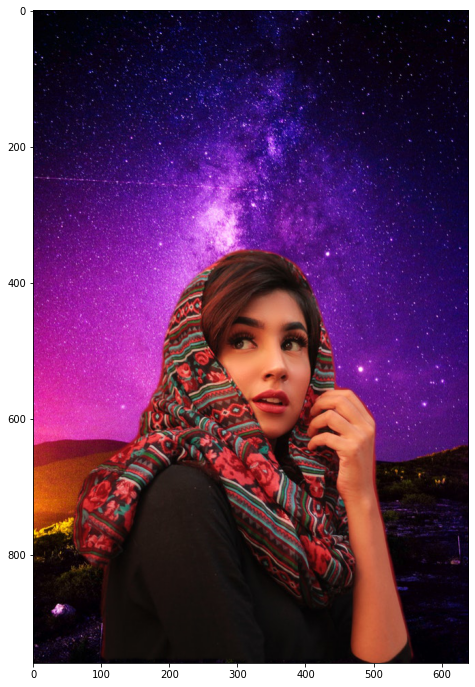

In [ ]:
result = cv2.add(foreground, background).astype(np.uint8)

Image.fromarray(result).save('result.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(result)
plt.show()

## Blur Background

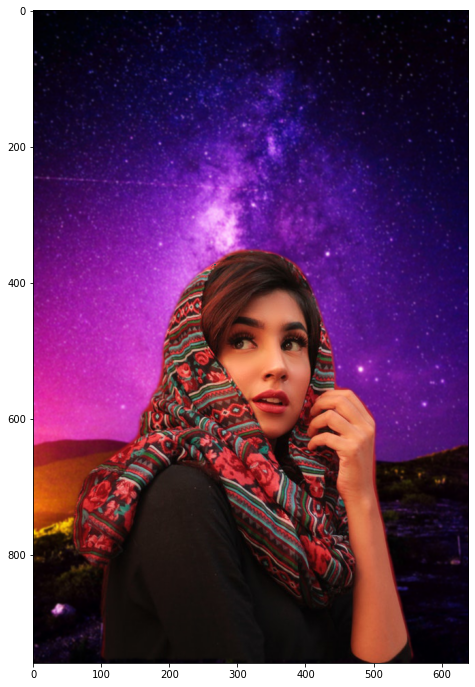

In [ ]:
blurred_background = cv2.GaussianBlur(background, (5, 5), 0).astype(float)

blurred_result = cv2.add(foreground, blurred_background).astype(np.uint8)

Image.fromarray(blurred_result).save('result_blurred.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(blurred_result)
plt.show()

## Grayscale Background

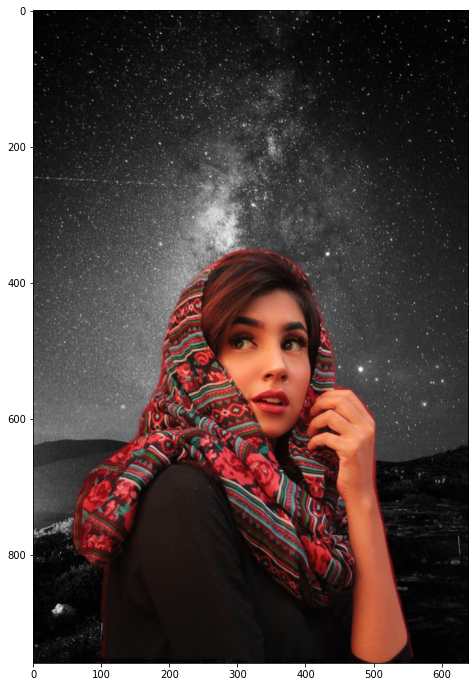

In [ ]:
gray_background = cv2.cvtColor(background.astype(np.uint8), cv2.COLOR_BGR2GRAY)

# 채널 수를 3채널로 만들기 위해 GRAY -> BGR로 변경
gray_background = cv2.cvtColor(gray_background, cv2.COLOR_GRAY2BGR).astype(float)

gray_result = cv2.add(foreground, gray_background).astype(np.uint8)

Image.fromarray(gray_result).save('result_gray.jpg')

plt.figure(figsize=(12, 12))
plt.imshow(gray_result)
plt.show()

## Other Result

(958, 640, 3)


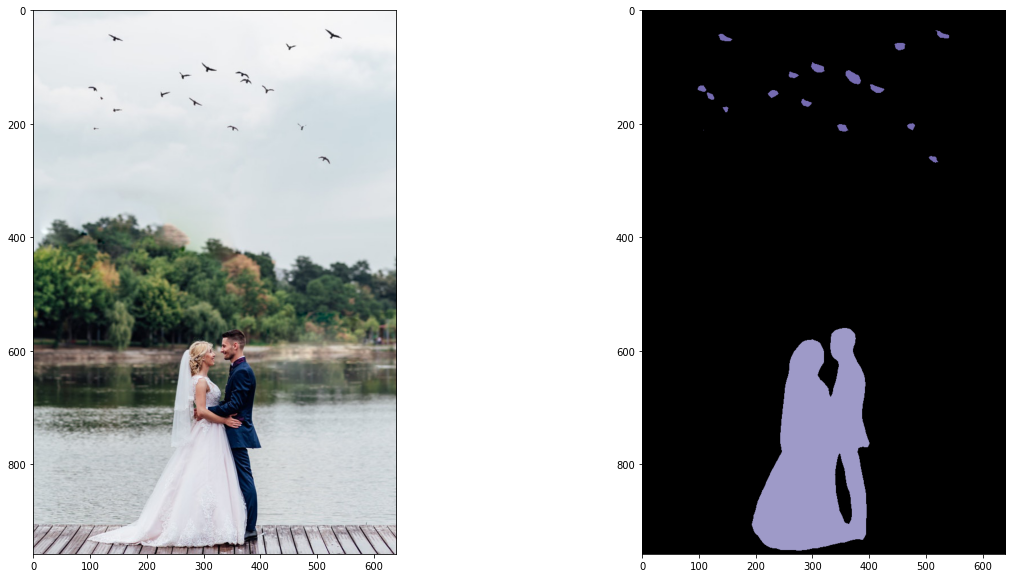

In [ ]:
root_path = '/content/gdrive/MyDrive/Project/Background_Image_Change_Semantic_Segmentation/Images/'
img = np.array(Image.open(root_path+'06.jpg'))

fg_h, fg_w, _ = img.shape
print(img.shape)

segment_map, pred = segment(model, img)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(segment_map)
plt.show()

(960, 640, 3)


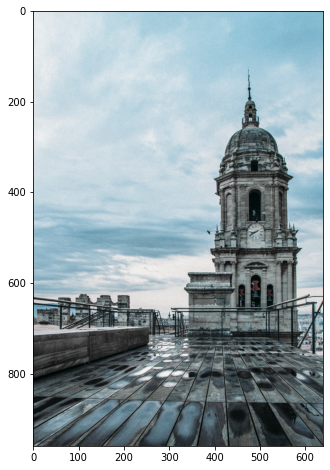

(958, 640, 3)


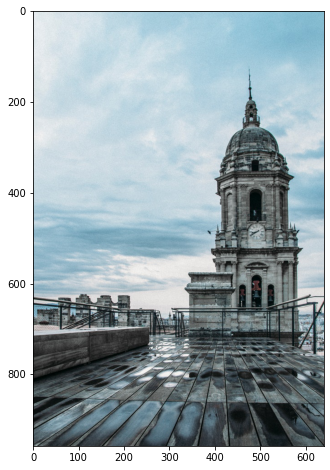

In [ ]:
background = np.array(Image.open(root_path + 'bg03.jpg'))
bg_h, bg_w, _ = background.shape

# fit to fg width
background = cv2.resize(background, dsize=(fg_w, int(fg_w * bg_h / bg_w)))
bg_h, bg_w, _ = background.shape

print(background.shape)
plt.figure(figsize=(12, 8))
plt.imshow(background)
plt.show()

margin = (bg_h - fg_h) // 2

if margin > 0:  # bg가 더 크면 크기에 맞게 위아래 자르기
    background = background[margin:-margin, :, :]
else:           # bg가 더 작으면 위아래 채워주기
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin),
                                    left=0, right=0, borderType=cv2.BORDER_REPLICATE)

# final resize
background = cv2.resize(background, dsize=(fg_w, fg_h))

print(background.shape)
plt.figure(figsize=(12, 8))
plt.imshow(background)
plt.show()

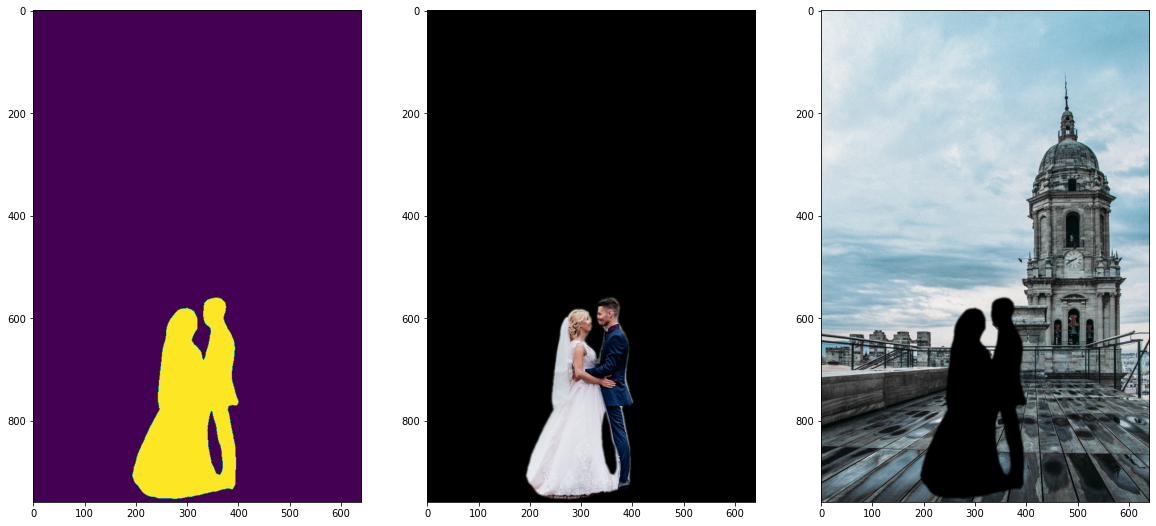

In [ ]:
mask = (pred == 15).astype(float) * 255  # 15 : person
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

alpha = alpha / 255.  # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2)  # (height, width, 3)

foreground = cv2.multiply(alpha, img.astype(float))
background = cv2.multiply(1. - alpha, background.astype(float))

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mask)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))
plt.show()

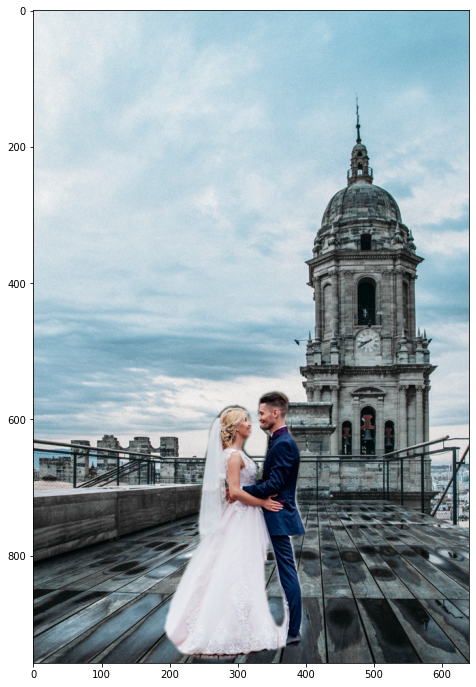

In [ ]:
result = cv2.add(foreground, background).astype(np.uint8)

plt.figure(figsize=(12, 12))
plt.imshow(result)
plt.show()

## Add Birds

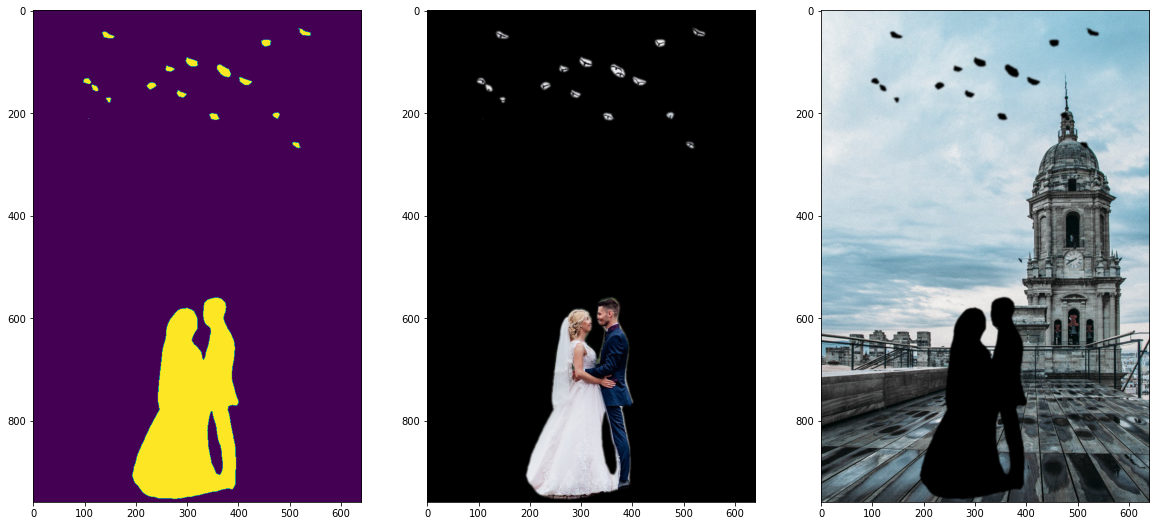

In [ ]:
mask = ((pred == 15)|(pred == 3)).astype(float) * 255  # 15:person, 3:bird
_, alpha = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

alpha = alpha / 255.  # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2)  # (height, width, 3)

foreground = cv2.multiply(alpha, img.astype(float))
background = cv2.multiply(1. - alpha, background.astype(float))

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mask)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))
plt.show()

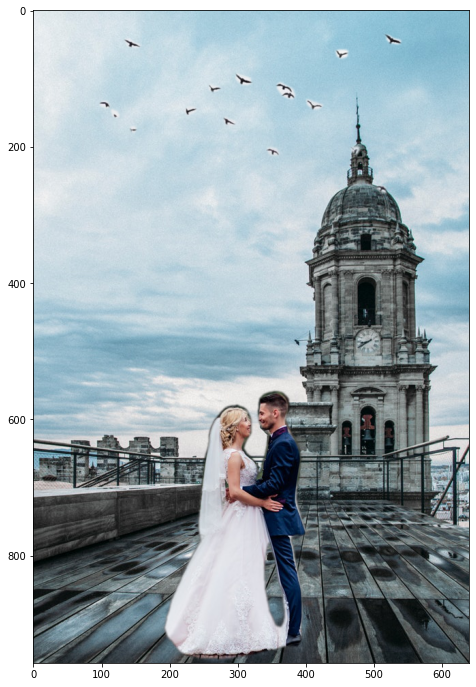

In [ ]:
result = cv2.add(foreground, background).astype(np.uint8)

plt.figure(figsize=(12, 12))
plt.imshow(result)
plt.show()